# Statistical test results for original dataset
Perform statistical tests to determine difference between the obtained trained models on the **balanced dataset**. Create a table with performance scores.

## Import useful packages

In [1]:
# Generic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import pickle

In [2]:
# Scikit-learn for vectorizers and performance metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, auc, f1_score, make_scorer, precision_recall_curve, matthews_corrcoef

In [3]:
# Keras preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import load_model
from keras.utils.data_utils import pad_sequences

In [4]:
# NLTK for natural language processing
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [5]:
# Custom helper-functions script (supplied to Colab manually)
import utils as uu

## Load data and assess performance

In [6]:
# Define file names
train_set_file = "train_set_imb_4.csv"
test_set_file  = "test_set_imb_4.csv"

In [7]:
# Set model-specific load and presentation parameters
models = []

# CNN model
models.append({
    "name":             "CNN",
    "linecolor":        'red',
    "linestyle":        '--', 
    "marker":           '.',
    "model_file":       "model_cnn_imb_4.h5",
    "vectorizer":       "KERAS",
    "is_dl_model":      True,
    "is_lex_model":     False,
    "max_features":     100000
        })

# RF model
models.append({
    "name":             "RF",
    "linecolor":        'orange',
    "linestyle":        '-', 
    "marker":           'v',
    "model_file":       "model_rf_imb_4.pckl",
    "vectorizer":       "COUNT",
    "is_dl_model":      False,
    "is_lex_model":     False,
    "max_features":     89403
        })

# LR model
models.append({
    "name":             "LR",
    "linecolor":        'green',
    "linestyle":        '-', 
    "marker":           '^',
    "model_file":       "model_lr_imb_4.pckl",
    "vectorizer":       "TFIDF",
    "is_dl_model":      False,
    "is_lex_model":     False,
    "max_features":     212435
        })

# FCNN model
models.append({
    "name":             "FCNN",
    "linecolor":        'deepskyblue',
    "linestyle":        '--', 
    "marker":           'o',
    "model_file":       "model_fcnn_imb_4.h5",
    "vectorizer":       "KERAS",
    "is_dl_model":      True,
    "is_lex_model":     False,
    "max_features":     100000
        })

# SVM model
models.append({
    "name":             "SVM",
    "linecolor":        'magenta',
    "linestyle":        '-', 
    "marker":           '+',
    "model_file":       "model_svm_imb_4.pckl",
    "vectorizer":       "TFIDF",
    "is_dl_model":      False,
    "is_lex_model":     False,
    "max_features":     2710
        })

# LSTM model
models.append({
    "name":             "LSTM",
    "linecolor":        'purple',
    "linestyle":        '--',
    "marker":           'None',
    "model_file":       "model_lstm_imb_4.h5",
    "vectorizer":       "KERAS",
    "is_dl_model":      True,
    "is_lex_model":     False,
    "max_features":     100000
        })

# NB model
models.append({
    "name":             "NB",
    "linecolor":        'lime',
    "linestyle":        '-', 
    "marker":           'x',
    "model_file":       "model_nb_imb_4.pckl",
    "vectorizer":       "COUNT",
    "is_dl_model":      False,
    "is_lex_model":     False,
    "max_features":     235808
        })

# KNN model
models.append({
    "name":             "KNN",
    "linecolor":        'blue',
    "linestyle":        '-', 
    "marker":           'None',
    "model_file":       "model_knn_imb_4.pckl",
    "vectorizer":       "TFIDF",
    "is_dl_model":      False,
    "is_lex_model":     False,
    "max_features":     100000
        })

# Lexicon model
models.append({
    "name":             "Lexicon",
    "linecolor":        'black',
    "linestyle":        '-.', 
    "marker":           'd',
    "model_file":       "NA",
    "vectorizer":       "NONE",
    "is_dl_model":      False,
    "is_lex_model":     True,
    "max_features":     100000
        })

In [8]:
# Set parameters for tokenization
max_words = 5000
max_len = 55

In [9]:
# Define a UL lexicon for label "1"
dict1 = ['climate',
 'climatechange',
 'globalwarming',
 'agw',
 'climaterealists']

In [10]:
# Compute performance

# Load datasets
train_set = pd.read_csv(train_set_file)
test_set = pd.read_csv(test_set_file)

# Preprocess texts
train_set['text'] = train_set['text'].apply(str)
train_set['text'] = train_set['text'].apply(uu.preprocess_text)
test_set['text'] = test_set['text'].apply(str)
test_set['text'] = test_set['text'].apply(uu.preprocess_text)

# Get features and labels
texts_train = copy.deepcopy(train_set['text'])
labels_train = copy.deepcopy(train_set['is_about_cc'])
texts_test = copy.deepcopy(test_set['text'])
labels_test = copy.deepcopy(test_set['is_about_cc'])

# Performance scores
n_models = len(models)
stat_test_stats = np.zeros((n_models, n_models))
stat_test_pvals = np.zeros((n_models, n_models))
stat_test_results = np.zeros((n_models, n_models))

model_names = []

for model1_idx in range(n_models):

  print("model1_idx = " + str(model1_idx))

  # Load model
  if (models[model1_idx]["is_dl_model"] == True):
    model1 = load_model(models[model1_idx]["model_file"])
  elif (models[model1_idx]["is_lex_model"] == False):
    model1 = pickle.load(open(models[model1_idx]["model_file"], 'rb'))

  model_names.append(models[model1_idx]["name"])
  
  if (models[model1_idx]["vectorizer"] == "KERAS"):
    # Tokenize features
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts_train)
    sequences_train = tokenizer.texts_to_sequences(texts_train)
    features_train = pad_sequences(sequences_train, maxlen=max_len, padding='post', truncating='post')
    sequences_test = tokenizer.texts_to_sequences(texts_test)
    features_test = pad_sequences(sequences_test, maxlen=max_len, padding='post', truncating='post')
  elif (models[model1_idx]["vectorizer"] == "TFIDF"):
    # Vectorize features
    vectorizer = TfidfVectorizer(max_features=models[model1_idx]["max_features"], lowercase=True, analyzer='word', dtype=np.float32)
    vectorizer.fit(texts_train)
    features_train = vectorizer.transform(texts_train)
    features_test = vectorizer.transform(texts_test)
  elif (models[model1_idx]["vectorizer"] == "COUNT"):
    vectorizer = CountVectorizer()
    vectorizer.fit(texts_train)
    features_train = vectorizer.transform(texts_train)
    features_test = vectorizer.transform(texts_test)
    
  # Predicted labels
  if (models[model1_idx]["is_lex_model"] == True):
    pred_labels_1 = [1 if any(word in text.split() for word in dict1) else 0 for text in texts_test]
  else:
    pred_labels_1 = (model1.predict(features_test) > 0.5).astype(int)

  for model2_idx in range(n_models):

    print("model2_idx = " + str(model2_idx))
    
    # Load model
    if (models[model2_idx]["is_dl_model"] == True):
      model2 = load_model(models[model2_idx]["model_file"])
    elif (models[model2_idx]["is_lex_model"] == False):
      model2 = pickle.load(open(models[model2_idx]["model_file"], 'rb'))

    if (models[model2_idx]["vectorizer"] == "KERAS"):
      # Tokenize features
      tokenizer = Tokenizer(num_words=max_words)
      tokenizer.fit_on_texts(texts_train)
      sequences_train = tokenizer.texts_to_sequences(texts_train)
      features_train = pad_sequences(sequences_train, maxlen=max_len, padding='post', truncating='post')
      sequences_test = tokenizer.texts_to_sequences(texts_test)
      features_test = pad_sequences(sequences_test, maxlen=max_len, padding='post', truncating='post')
    elif (models[model2_idx]["vectorizer"] == "TFIDF"):
      # Vectorize features
      vectorizer = TfidfVectorizer(max_features=models[model2_idx]["max_features"], lowercase=True, analyzer='word', dtype=np.float32)
      vectorizer.fit(texts_train)
      features_train = vectorizer.transform(texts_train)
      features_test = vectorizer.transform(texts_test)
    elif (models[model2_idx]["vectorizer"] == "COUNT"):
      vectorizer = CountVectorizer()
      vectorizer.fit(texts_train)
      features_train = vectorizer.transform(texts_train)
      features_test = vectorizer.transform(texts_test)
      
    # Predicted labels
    if (models[model2_idx]["is_lex_model"] == True):
      pred_labels_2 = [1 if any(word in text.split() for word in dict1) else 0 for text in texts_test]
    else:
      pred_labels_2 = (model2.predict(features_test) > 0.5).astype(int)

    # Contigency table
    print(len(pred_labels_1))
    print(len(pred_labels_2))
    print(len(labels_test))
    contigency_table = uu.compute_contingency_table(pred_labels_1, pred_labels_2, labels_test)

    # Stat test scores
    if (model1_idx!=model2_idx):
      stats, pval, reject_null_hyp = uu.perform_mcnemar_test(contigency_table, significance=0.05)
      stat_test_stats[model1_idx][model2_idx] = stats
      stat_test_pvals[model1_idx][model2_idx] = pval
      stat_test_results[model1_idx][model2_idx] = reject_null_hyp
    else:
      stat_test_stats[model1_idx][model2_idx] = np.nan
      stat_test_pvals[model1_idx][model2_idx] = np.nan
      stat_test_results[model1_idx][model2_idx] = np.nan

model1_idx = 0
50/50 [==============================] - 2s 5ms/step
model2_idx = 0
50/50 [==============================] - 0s 4ms/step
1596
1596
1596
[[47, 0], [0, 1549]]
model2_idx = 1


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1596
1596
1596
[[26, 21], [21, 1528]]
model2_idx = 2


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1596
1596
1596
[[37, 10], [12, 1537]]
model2_idx = 3
50/50 [==============================] - 0s 5ms/step
1596
1596
1596
[[43, 4], [8, 1541]]
model2_idx = 4


<ipython-input-10-18dbb5c43a5d>:73: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  model2 = pickle.load(open(models[model2_idx]["model_file"], 'rb'))
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1596
1596
1596
[[34, 13], [17, 1532]]
model2_idx = 5
50/50 [==============================] - 2s 8ms/step
1596
1596
1596
[[41, 6], [21, 1528]]
model2_idx = 6


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator MultinomialNB from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1596
1596
1596
[[35, 12], [28, 1521]]
model2_idx = 7


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


1596
1596
1596
[[28, 19], [138, 1411]]
model2_idx = 8
1596
1596
1596
[[27, 20], [172, 1377]]
model1_idx = 1
model2_idx = 0
50/50 [==============================] - 0s 3ms/step
1596
1596
1596
[[26, 21], [21, 1528]]
model2_idx = 1
1596
1596
1596
[[47, 0], [0, 1549]]
model2_idx = 2
1596
1596
1596
[[36, 11], [13, 1536]]
model2_idx = 3
50/50 [==============================] - 0s 3ms/step
1596
1596
1596
[[27, 20], [24, 1525]]
model2_idx = 4
1596
1596
1596
[[36, 11], [15, 1534]]
model2_idx = 5
50/50 [==============================] - 1s 7ms/step
1596
1596
1596
[[25, 22], [37, 1512]]
model2_idx = 6
1596
1596
1596
[[28, 19], [35, 1514]]
model2_idx = 7
1596
1596
1596
[[21, 26], [145, 1404]]
model2_idx = 8
1596
1596
1596
[[39, 8], [160, 1389]]
model1_idx = 2
model2_idx = 0
50/50 [==============================] - 0s 5ms/step
1596
1596
1596
[[37, 12], [10, 1537]]
model2_idx = 1
1596
1596
1596
[[36, 13], [11, 1536]]
model2_idx = 2
1596
1596
1596
[[49, 0], [0, 1547]]
model2_idx = 3
50/50 [==========

<ipython-input-10-18dbb5c43a5d>:35: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  model1 = pickle.load(open(models[model1_idx]["model_file"], 'rb'))


model2_idx = 0
50/50 [==============================] - 0s 3ms/step
1596
1596
1596
[[34, 17], [13, 1532]]
model2_idx = 1
1596
1596
1596
[[36, 15], [11, 1534]]
model2_idx = 2
1596
1596
1596
[[42, 9], [7, 1538]]
model2_idx = 3
50/50 [==============================] - 0s 3ms/step
1596
1596
1596
[[36, 15], [15, 1530]]
model2_idx = 4
1596
1596
1596
[[51, 0], [0, 1545]]
model2_idx = 5
50/50 [==============================] - 1s 6ms/step
1596
1596
1596
[[36, 15], [26, 1519]]
model2_idx = 6
1596
1596
1596
[[33, 18], [30, 1515]]
model2_idx = 7
1596
1596
1596
[[27, 24], [139, 1406]]
model2_idx = 8
1596
1596
1596
[[36, 15], [163, 1382]]
model1_idx = 5
50/50 [==============================] - 1s 9ms/step
model2_idx = 0
50/50 [==============================] - 0s 3ms/step
1596
1596
1596
[[41, 21], [6, 1528]]
model2_idx = 1
1596
1596
1596
[[25, 37], [22, 1512]]
model2_idx = 2
1596
1596
1596
[[35, 27], [14, 1520]]
model2_idx = 3
50/50 [==============================] - 0s 3ms/step
1596
1596
1596
[[41

In [11]:
# Performance results
print(stat_test_stats)
print(stat_test_pvals)
print(stat_test_results)

[[           nan 2.38095238e-02 4.54545455e-02 7.50000000e-01
  3.00000000e-01 7.25925926e+00 5.62500000e+00 8.86878981e+01
  1.18755208e+02]
 [2.38095238e-02            nan 4.16666667e-02 2.04545455e-01
  3.46153846e-01 3.32203390e+00 4.16666667e+00 8.14269006e+01
  1.35720238e+02]
 [4.54545455e-02 4.16666667e-02            nan 3.84615385e-02
  6.25000000e-02 3.51219512e+00 4.02380952e+00 8.57070064e+01
  1.24724719e+02]
 [7.50000000e-01 2.04545455e-01 3.84615385e-02            nan
  3.33333333e-02 3.22580645e+00 2.63043478e+00 7.97300613e+01
  1.13731579e+02]
 [3.00000000e-01 3.46153846e-01 6.25000000e-02 3.33333333e-02
             nan 2.43902439e+00 2.52083333e+00 7.97300613e+01
  1.21398876e+02]
 [7.25925926e+00 3.32203390e+00 3.51219512e+00 3.22580645e+00
  2.43902439e+00            nan 0.00000000e+00 7.26643836e+01
  8.76587678e+01]
 [5.62500000e+00 4.16666667e+00 4.02380952e+00 2.63043478e+00
  2.52083333e+00 0.00000000e+00            nan 7.59416058e+01
  8.51635514e+01]
 [8.86

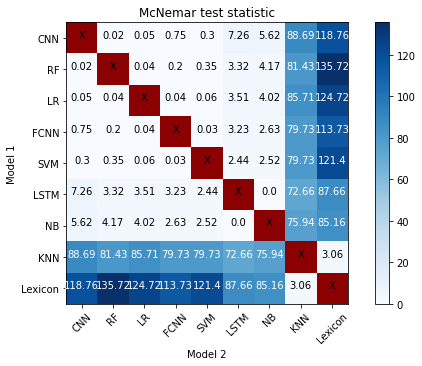

In [12]:
uu.plot_stats_matrix(stat_test_stats, model_names, plot_type='CHI_2_STAT')
plt.savefig('fig_chi2_imb.pdf')

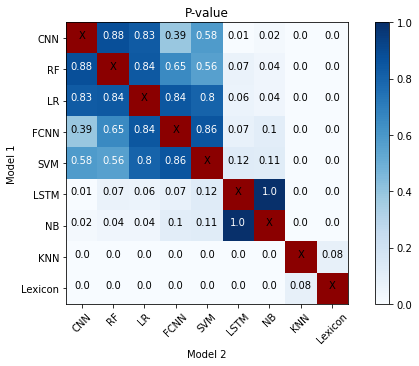

In [13]:
uu.plot_stats_matrix(stat_test_pvals, model_names, plot_type='P_VAL')
plt.savefig('fig_pvals_imb.pdf')

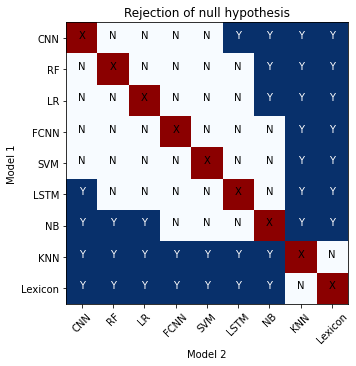

In [14]:
uu.plot_rejection_matrix(stat_test_results, model_names)
plt.savefig('fig_rejects_imb.pdf')